In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

## R-Squared 계산 함수 정의
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

## 교차 검증을 수행하는 함수 정의
def cross_validation(model, X, y, n=5):
    cv = KFold(n, shuffle=False)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 입력 변수 가중치
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)


#
# 1. Data Load
- Cape의 경우 BDI 정보가 없음

In [11]:
#data = pd.read_excel('PERFORMANCE_DATA_V3.xlsx')
data = pd.read_excel("https://raw.githubusercontent.com/coj918/github_from_HD/master/PERFORMANCE_DATA_TR.xlsx")
data.columns = ['No', 'YEAR_MONTH', 'CB_TYPE', 'VSL_TYPE', 'TC_TYPE', 'VSL_CNT', 'TRD_ROUTE_CODE','CGO_CODE','FIRST_LDG_PORT','LAST_DIS_PORT',
                'CB_TEAM_CODE', 'CB_INDEX', 'DURATION', 'BUNKER_PRICE', 'DAY_CB', 'DAY_HIRE',
                'TC INDEX', 'PL']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22075 entries, 0 to 22074
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   No              22075 non-null  int64         
 1   YEAR_MONTH      22075 non-null  datetime64[ns]
 2   CB_TYPE         22075 non-null  object        
 3   VSL_TYPE        22075 non-null  object        
 4   TC_TYPE         22075 non-null  object        
 5   VSL_CNT         22075 non-null  int64         
 6   TRD_ROUTE_CODE  22075 non-null  object        
 7   CGO_CODE        22075 non-null  object        
 8   FIRST_LDG_PORT  22075 non-null  object        
 9   LAST_DIS_PORT   22075 non-null  object        
 10  CB_TEAM_CODE    22075 non-null  int64         
 11  CB_INDEX        22075 non-null  int64         
 12  DURATION        22075 non-null  float64       
 13  BUNKER_PRICE    22075 non-null  float64       
 14  DAY_CB          22075 non-null  int64         
 15  DA

### 1-1) 팀 코드 숫자 -> 문자열 변환

In [13]:
data = data.astype({'CB_TEAM_CODE':'str'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22075 entries, 0 to 22074
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   No              22075 non-null  int64         
 1   YEAR_MONTH      22075 non-null  datetime64[ns]
 2   CB_TYPE         22075 non-null  object        
 3   VSL_TYPE        22075 non-null  object        
 4   TC_TYPE         22075 non-null  object        
 5   VSL_CNT         22075 non-null  int64         
 6   TRD_ROUTE_CODE  22075 non-null  object        
 7   CGO_CODE        22075 non-null  object        
 8   FIRST_LDG_PORT  22075 non-null  object        
 9   LAST_DIS_PORT   22075 non-null  object        
 10  CB_TEAM_CODE    22075 non-null  object        
 11  CB_INDEX        22075 non-null  int64         
 12  DURATION        22075 non-null  float64       
 13  BUNKER_PRICE    22075 non-null  float64       
 14  DAY_CB          22075 non-null  int64         
 15  DA

In [14]:
data.isnull().sum()

No                0
YEAR_MONTH        0
CB_TYPE           0
VSL_TYPE          0
TC_TYPE           0
VSL_CNT           0
TRD_ROUTE_CODE    0
CGO_CODE          0
FIRST_LDG_PORT    0
LAST_DIS_PORT     0
CB_TEAM_CODE      0
CB_INDEX          0
DURATION          0
BUNKER_PRICE      0
DAY_CB            0
DAY_HIRE          0
TC INDEX          0
PL                0
dtype: int64

In [ ]:
data[:3]

,No,Date,Line,Type,Owned,Vsl_Cnt,Cargo,Team,BDI,Duration,Bunker,Daily_CB,Daily_Hire,TC Index,PL
0,1,2015-01-01,TR,Cape,OWNED,4,BF00,63,627,120.083,469.27,10775,0,0,10775
1,2,2015-01-01,TR,Cape,OWNED,2,BB00,63,627,8.921,359.25,444,0,0,444
2,3,2015-01-01,TR,Cape,OWNED,13,BF00,64,627,342.229,521.86,32631,0,0,32631


### 1-2) datetime 분해

In [ ]:
data["d-month"] = data["Date"].dt.month

In [ ]:
data[-3:]

,No,Date,Line,Type,Owned,Vsl_Cnt,Cargo,Team,BDI,Duration,Bunker,Daily_CB,Daily_Hire,TC Index,PL,d-month
5943,5944,2023-08-01,LN,S'max,TC,32,BM00,282,805,615.176,608.25,6926,8059,8860,-1133,8
5944,5945,2023-08-01,LN,S'max,TC,9,BM00,283,805,119.175,599.24,7614,6639,8860,975,8
5945,5946,2023-08-01,TR,S'max,TC,1,BC00,283,805,31.000,0.00,6200,15208,8860,-9008,8


In [ ]:
#1-2-1) COJ BDI 공란을 여기에 채우기
#NULL값은 그 이전일자 값을 가져온다.
#1) BDI값 가져오기
power = pd.read_csv("https://raw.githubusercontent.com/coj918/github_from_HD/master/INDEX_BDI_20150101_20230831.csv",parse_dates=['IDX_YMD'])
power.set_index("IDX_YMD", inplace=True)

print(power.shape)
power[:3]

df2 = power[:]
df2[:3]
df2.info()

#2)컬럼명 지정
df = df2.resample('D').sum()
df.reset_index(inplace=True)
#df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
df
df.info()

#3) 지수를 매일 발표하는 건 아니므로 값이 0 인 건은 이전일자의 값을 그대로 가져간다.
for i in range(len(df)):
  if df.loc[i,'y']==0 :
     df.loc[i,'y']=df.loc[i-1,'y']
df


(2164, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2164 entries, 2015-01-02 to 2023-08-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   IDX_AMT  2164 non-null   int64
dtypes: int64(1)
memory usage: 33.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3164 non-null   datetime64[ns]
 1   y       3164 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.6 KB


,ds,y
0,2015-01-02,771
1,2015-01-03,771
2,2015-01-04,771
3,2015-01-05,761
4,2015-01-06,758
...,...,...
3159,2023-08-27,1080
3160,2023-08-28,1080
3161,2023-08-29,1107
3162,2023-08-30,1094


In [ ]:
#1-2-2) 이전일자 BDI 끼우기위해 NULL값은 0 셋팅
data.loc[data.BDI.isnull(),'BDI']=0
data[data.BDI.isnull()]

,No,Date,Line,Type,Owned,Vsl_Cnt,Cargo,Team,BDI,Duration,Bunker,Daily_CB,Daily_Hire,TC Index,PL,d-month


In [ ]:
#1-2-3) 이전일자 BDI
for i in range(len(data)):
  if data.loc[i,'BDI']==0:
    for j in range(len(df)) :
      if data.loc[i,'DATE']==df.loc[j,'DATE']:
        data.loc[i,'BDI']=df.loc[j,'BDI']

#
# 2. 불필요 컬럼 삭제
- 대상 : No, Duration, Bunker, TC Index, PL

In [ ]:
data = data.drop(columns=['No', 'Duration', 'Bunker', 'TC Index', 'PL'], axis=1)
data[:3]

,Date,Line,Type,Owned,Vsl_Cnt,Cargo,Team,BDI,Daily_CB,Daily_Hire,d-month
0,2015-01-01,TR,Cape,OWNED,4,BF00,63,627,10775,0,1
1,2015-01-01,TR,Cape,OWNED,2,BB00,63,627,444,0,1
2,2015-01-01,TR,Cape,OWNED,13,BF00,64,627,32631,0,1


In [ ]:
data.Date.min(), data.Date.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))

#
# 3. 사선 항목 분리
- 사선의 경우 Daily_Hire 항목 불필요

In [ ]:
df_owned = data[data.Owned == 'OWNED'].drop(columns=['Owned', 'Daily_Hire'], axis=1)
df_owned.set_index('Date', inplace=True)
df_owned[:3]

,Line,Type,Vsl_Cnt,Cargo,Team,BDI,Daily_CB,d-month
Date,,,,,,,,
2015-01-01,TR,Cape,4,BF00,63,627,10775,1
2015-01-01,TR,Cape,2,BB00,63,627,444,1
2015-01-01,TR,Cape,13,BF00,64,627,32631,1


#
# 4. 수치 항목 log 변환

### 4-1) log 변환

In [ ]:
#df_owned.BDI, df_owned.Daily_CB = np.log([df_owned.BDI + 1, df_owned.Daily_CB])
#df_owned.BDI = np.log(df_owned.BDI + 1)
#bdi+1e-7 로 수정
df_owned.BDI = np.log(df_owned.BDI+ 1e-7)
df_owned[:3]

,Line,Type,Vsl_Cnt,Cargo,Team,BDI,Daily_CB,d-month
Date,,,,,,,,
2015-01-01,TR,Cape,4,BF00,63,6.440947,10775,1
2015-01-01,TR,Cape,2,BB00,63,6.440947,444,1
2015-01-01,TR,Cape,13,BF00,64,6.440947,32631,1


### 4-2) 로그 변환 후 데이터 셋

In [ ]:
df_owned.isnull().sum(), df_owned.shape

(Line        0
 Type        0
 Vsl_Cnt     0
 Cargo       0
 Team        0
 BDI         8
 Daily_CB    0
 d-month     0
 dtype: int64,
 (2035, 8))

### 4-3) 로그 변환 후 NULL ??

In [ ]:
df_owned[df_owned.BDI.isnull()]

,Line,Type,Vsl_Cnt,Cargo,Team,BDI,Daily_CB,d-month
Date,,,,,,,,
2020-02-01,TR,Cape,2,BB00,63,NaN,9477,2
2020-02-01,TR,Cape,7,BF00,63,NaN,7136,2
2020-02-01,TR,Cape,12,BF00,64,NaN,38806,2
2020-02-01,TR,Cape,10,BB00,64,NaN,20938,2
2020-03-01,TR,Cape,7,BF00,63,NaN,5247,3
2020-03-01,TR,Cape,1,BB00,63,NaN,2412,3
2020-03-01,TR,Cape,12,BF00,64,NaN,34745,3
2020-03-01,TR,Cape,10,BB00,64,NaN,21367,3


### 4-4) NULL 건은 어떻게 처리???? (우선은 삭제)

In [ ]:
print(df_owned.shape)
df_owned = df_owned.dropna(axis=0)
print(df_owned.shape)

(2035, 8)
(2027, 8)


#
# 5. One-Hot Encoding + Scaler 비교
- OneHotEncoder + make_colum_tranformer 사용

### 5-1) Function 정의

In [ ]:
from sklearn.compose import make_column_transformer

def column_transformer(scaler):
    mct = make_column_transformer(
        (scaler, ['Vsl_Cnt','BDI','d-month']),
        (OneHotEncoder(sparse_output=False), ['Line', 'Type', 'Cargo', 'Team'])
    )
    return mct

### 5-2) X, y 데이터 분리

In [ ]:
X_owned = df_owned.drop('Daily_CB', axis=1)
y_owned = df_owned.Daily_CB
X_owned.shape, y_owned.shape

((2027, 7), (2027,))

In [ ]:
X_owned[:3]

,Line,Type,Vsl_Cnt,Cargo,Team,BDI,d-month
Date,,,,,,,
2015-01-01,TR,Cape,4,BF00,63,6.44254,1
2015-01-01,TR,Cape,2,BB00,63,6.44254,1
2015-01-01,TR,Cape,13,BF00,64,6.44254,1


### 5-3) StandardScaler, MinMaxScaler 비교

Standard:  (2027, 39)
MinMaxScaler :  (2027, 39)
QuantileTransformer :  (2027, 39)


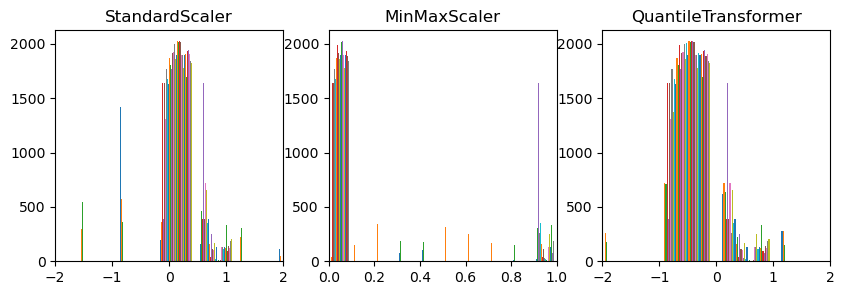

In [ ]:
plt.figure(figsize=(10,3))

# 1. StandardSacler
standard = StandardScaler()
cst = column_transformer(standard)
X_cst = cst.fit_transform(X_owned)

plt.subplot(1, 3, 1)
plt.title('StandardScaler')
plt.xlim(-2,2)
plt.hist(X_cst)
print('Standard: ', X_cst.shape)

# 2. MinMaxScaler
minmax = MinMaxScaler()
mima = column_transformer(minmax)
X_mima = mima.fit_transform(X_owned)

plt.subplot(1, 3, 2)
plt.title('MinMaxScaler')
plt.xlim(0,1)
plt.hist(X_mima)
print('MinMaxScaler : ', X_mima.shape)

# 3. QuantileTransformer
quantile = QuantileTransformer(n_quantiles=50, output_distribution='normal')
quant = column_transformer(quantile)
X_quant = quant.fit_transform(X_owned)

plt.subplot(1, 3, 3)
plt.title('QuantileTransformer')
plt.xlim(-2,2)
plt.hist(X_quant)
print('QuantileTransformer : ', X_quant.shape)

In [ ]:
X_quant.shape

(2027, 39)

## 5. Scaler 비교 결과 : QuantileTransformer Scaler 선택 (X_quant)

#
# 6. 모델 테스트

### * 훈련 데이터/테스트 데이터를 통한 시각화 Function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features(features, target, n_train, model):

    X = df_owned.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_owned.index.min(), end=df_owned.index.max(), freq='M')
    #print(xticks)

    # 년도와 월을 추출하여 xticks_name을 생성합니다.
    xticks_name = [date.strftime("%Y-%m") for date in xticks]
    #month = ["Jan", "Feb", "Mar","Apr", "May", "Jun", "Jul", "Aug", 'Oct', 'Sep', 'Nov', 'Dec']
    #xticks_name = [month[int(m)]+d for m, d in zip(xticks.strftime("%m"),xticks.strftime(" %m-%d"))]
    #plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    #print(xticks_name)

    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    #X_train, X_test, y_train, y_test = train_test_split(features, target)

    model.fit(X_train, y_train)
    print('Train : {:.2f}'.format(model.score(X_train, y_train)))
    print('Test : {:.2f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    #plt.xticks(range(0, len(xticks_name), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
    plt.plot(range(n_train), y_pred_train, '--', label="Train Pred")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Test Pred")

    plt.legend(loc='best')
    plt.title(model)
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")

    return y_train, y_test, y_pred

### 6-1) LinearRegression
- 훈련 세트 : 2015/01 ~ 2021/12, 테스트 세트 : 2022/01 ~ 2023/07

Train : 0.63
Test : -0.22


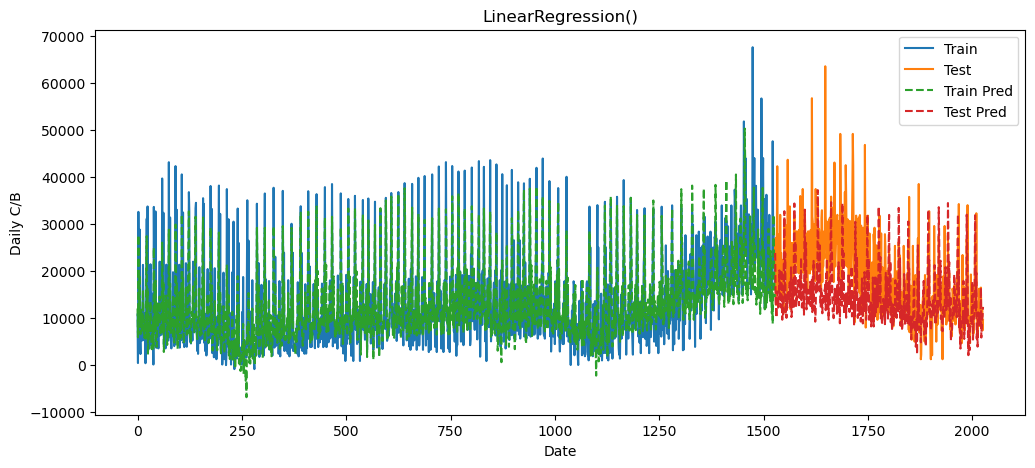

In [ ]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features(X_quant, y_owned, 1528, LinearRegression())

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  46227.926
Mean Absolute Error:  7293.23
Root Mean Squared Error:  9867.076
R-Squared:  -0.223


### 6-2) Lasso
- 훈련 세트 : 2015/01 ~ 2021/12, 테스트 세트 : 2022/01 ~ 2023/07

Train : 0.63
Test : -0.22


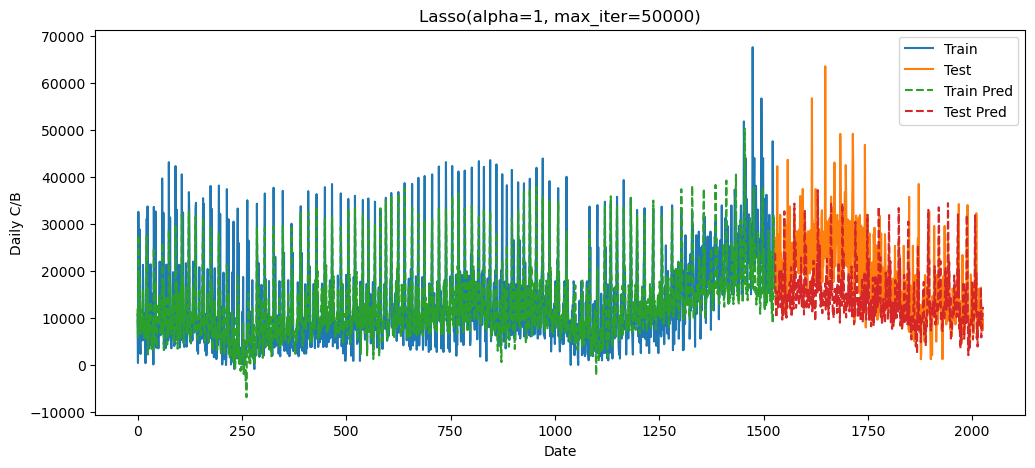

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1, max_iter=50000)
y_train, y_test, y_pred = eval_on_features(X_quant, y_owned, 1528, lasso)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  46234.1
Mean Absolute Error:  7291.497
Root Mean Squared Error:  9869.052
R-Squared:  -0.223


Train : 0.63
Test : -0.22


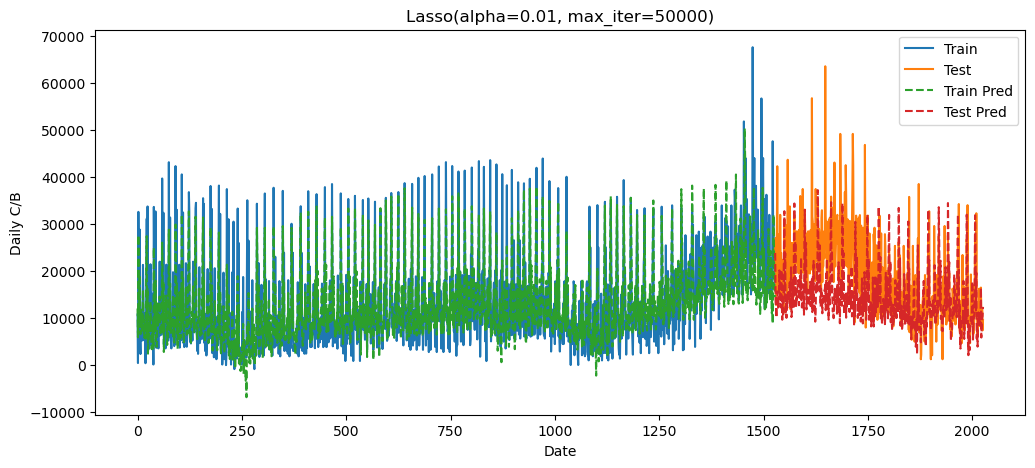

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01, max_iter=50000)
y_train, y_test, y_pred = eval_on_features(X_quant, y_owned, 1528, lasso)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  46227.968
Mean Absolute Error:  7293.218
Root Mean Squared Error:  9867.099
R-Squared:  -0.223


### 6-3) RandomForest
- 훈련 세트 : 2015/01 ~ 2021/12, 테스트 세트 : 2022/01 ~ 2023/07

Train : 0.97
Test : -0.10


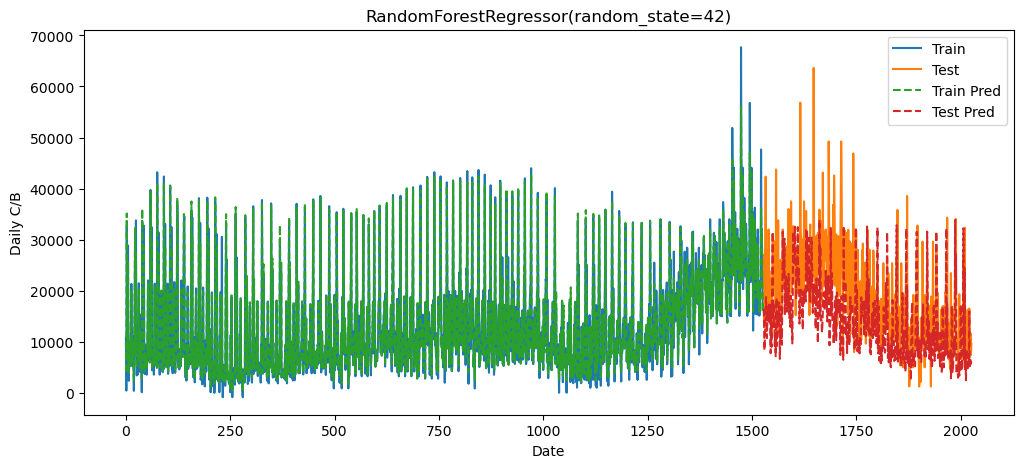

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
y_train, y_test, y_pred = eval_on_features(X_quant, y_owned, 1528, rf)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  45193.11
Mean Absolute Error:  6878.712
Root Mean Squared Error:  9366.028
R-Squared:  -0.102


### 6-4) LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 32
[LightGBM] [Info] Start training from score 13090.666230
Train : 0.91
Test : -0.12


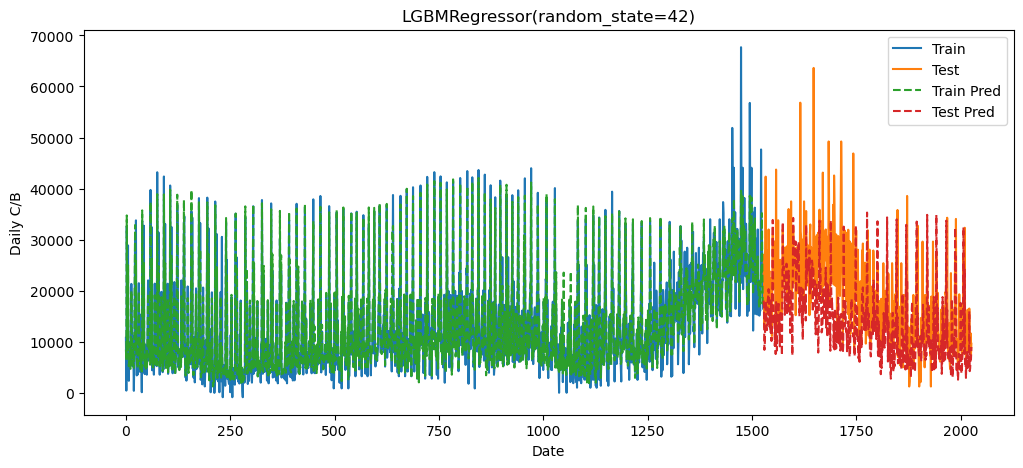

In [ ]:
lgbm = LGBMRegressor(random_state=42)
y_train, y_test, y_pred = eval_on_features(X_quant, y_owned, 1528, lgbm)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  43935.538
Mean Absolute Error:  6894.204
Root Mean Squared Error:  9448.505
R-Squared:  -0.121


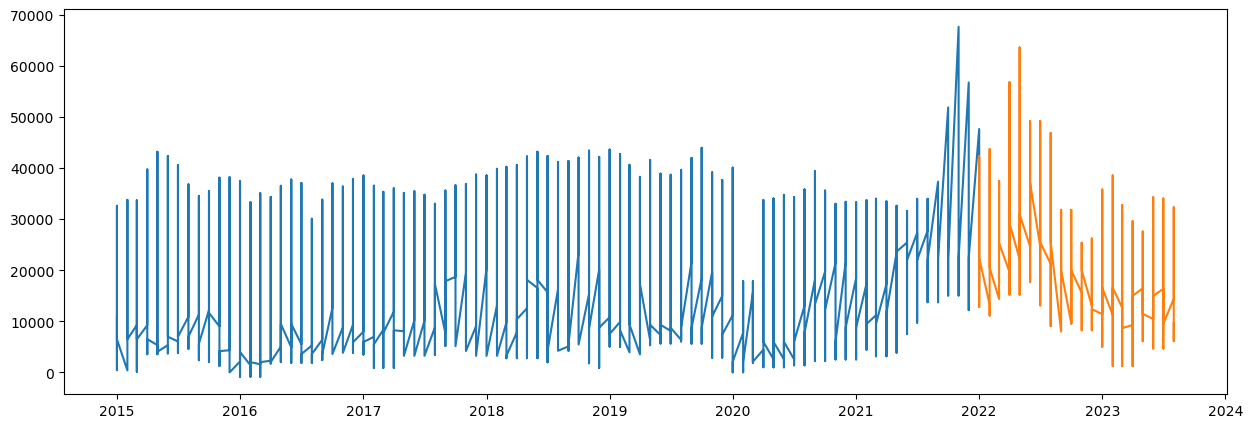

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_owned[:1528])
plt.plot(y_owned[1528:])

## 6. 모델 테스트 결과 : LSTM이 아직은 불확실 하여 RandomForest로 우선 진행

#
# 7. 특성 선택 (RFE)
- LinearRegressor, Lasso, RandomForest 중 R-Squared가 가장 높은 RandomForest로 진행

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(
    RandomForestRegressor(n_estimators=100, random_state=42),
                          n_features_to_select=20 # 현 38개 -> 20개로 축소
)

n_train = 1528
X_train, X_test = X_quant[:n_train], X_quant[n_train:]
y_train, y_test = y_owned[:n_train], y_owned[n_train:]

rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
print(X_train.shape), print(X_test_rfe.shape)

rf = RandomForestRegressor(n_estimators=1000, random_state=42)

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train)), print(rf.score(X_test, y_test))

rf.fit(X_train_rfe, y_train)
print(rf.score(X_train_rfe, y_train)), print(rf.score(X_test_rfe, y_test))

(1528, 39)
(499, 20)
0.9747857351994657
-0.09955655450037892
0.9702125784967748
-0.09017907217725152


(None, None)

## 7. 특성 선택 결과 : 선택 영향 없음, 현행 유지

#
# 8. K-Fold 교차 검증

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

X = X_quant
y = y_owned

rf = RandomForestRegressor(n_estimators=1000, random_state=0)

kfold = KFold(n_splits=5, shuffle=False)
score = cross_val_score(rf, X, y, cv=kfold)
score

array([ 0.71697387,  0.64584308,  0.59501722, -0.36093975,  0.06288146])

In [ ]:
score.mean()

0.33195517567442634

# 9. 매개변수 조정 및 훈련, 검증, 테스트 데이터 분리

In [ ]:
n_train = 1528

X_n_train, X_test = X_quant[:n_train], X_quant[n_train:]
y_n_train, y_test = y_owned[:n_train], y_owned[n_train:]

X_train, X_validate, y_train, y_validate = train_test_split(
                     X_n_train, y_n_train, shuffle=False, random_state=42)

best_score = 0
best_para ={}

for estimater in [5, 10, 100, 1000]:

        rf = RandomForestRegressor(n_estimators=estimater, random_state=42)
        rf.fit(X_train, y_train)
        score = rf.score(X_validate, y_validate)

        print('n_estimators = ', estimater, ', score = ', score)
        if score > best_score:
            best_score = score
            best_para = {'n_estimators':estimater}

rf_best = RandomForestRegressor(**best_para)
rf_best.fit(X_n_train, y_n_train)
score = rf_best.score(X_test, y_test)

print('검증 Best 점수 : ', best_score, 'Test 점수 : ', score, 'Best n_estimators=', best_para)


n_estimators =  5 , score =  -0.3183624807179335
n_estimators =  10 , score =  -0.2631390237329354
n_estimators =  100 , score =  -0.19022041133815937
n_estimators =  1000 , score =  -0.19061900613003768
검증 Best 점수 :  0 Test 점수 :  -0.10692297187337774 Best n_estimators= {}


## 9. 훈련, 검증, 테스트 데이터 분리 결과 : 의미없음

#
# 10. 향후 과제

### 10-1) LSTM 진행

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
data = pd.read_excel("TimeSeries.xlsx", engine='openpyxl')
data.columns = ['No', 'Date', 'Line', 'Type', 'Owned', 'Vsl_Cnt', 'Cargo',
                'Team', 'BDI', 'Daily_CB']
data = data.drop(columns=['No'], axis=1)
data.set_index('Date', inplace=True)  # DATE 열을 인덱스로 설정
data = pd.get_dummies(data, columns=['Line', 'Type', 'Owned', 'Cargo', 'Team'])
data.BDI = np.log(data.BDI + 1)

data = data.dropna()  # 결측치 제거
data[:3]


,Vsl_Cnt,BDI,Daily_CB,Line_LN,Line_TR,Type_Cape,Type_Handy,Type_P'max,Type_S'max,Owned_OWNED,...,Team_64,Team_165,Team_170,Team_231,Team_233,Team_254,Team_255,Team_267,Team_282,Team_283
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,4,6.44254,10775,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2015-01-01,2,6.44254,444,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2015-01-01,13,6.44254,32631,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# 입력 데이터를 3차원으로 변환
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:i+look_back, :-1].values)
        y.append(data.iloc[i+look_back, -1])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_sequences(data, look_back)

scaler = MinMaxScaler()
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])  # 3차원 배열을 2차원으로 변환
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

# 다시 LSTM 입력 형태로 변환
X = X.reshape(X.shape[0], look_back, X.shape[1] // look_back)

Epoch 1/200
51/51 [==============================] - 4s 9ms/step - loss: 0.0315
Epoch 2/200
51/51 [==============================] - 0s 9ms/step - loss: 0.0283
Epoch 3/200
51/51 [==============================] - 0s 10ms/step - loss: 0.0273
Epoch 4/200
51/51 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 5/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0250
Epoch 6/200
51/51 [==============================] - 0s 9ms/step - loss: 0.0241
Epoch 7/200
51/51 [==============================] - 1s 11ms/step - loss: 0.0226
Epoch 8/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0220
Epoch 9/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0216
Epoch 10/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0215
Epoch 11/200
51/51 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 12/200
51/51 [==============================] - 0s 10ms/step - loss: 0.0192
Epoch 13/200
51/51 [=========

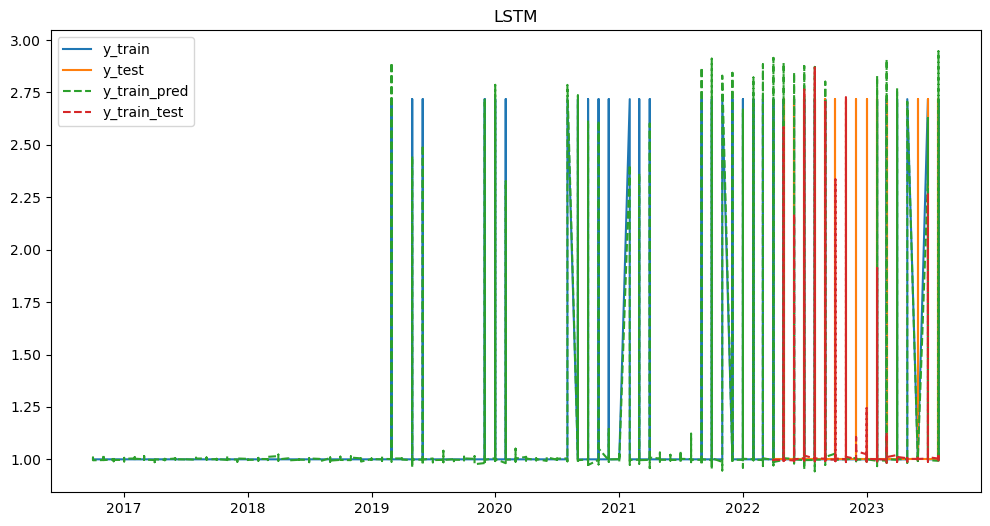

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(100, input_shape=(look_back, X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred = np.exp(scaler.inverse_transform(y_train_pred))
y_test_pred  = np.exp(scaler.inverse_transform(y_test_pred))
y_train_true = np.exp(scaler.inverse_transform(y_train))
y_test_true  = np.exp(scaler.inverse_transform(y_test))

plt.figure(figsize=(12, 6))
plt.title('LSTM')
plt.plot(data.index[-len(y_train_pred):], y_train_true, label='y_train')
plt.plot(data.index[-len(y_test_pred):], y_test_true, label='y_test')
plt.plot(data.index[-len(y_train_pred):], y_train_pred, label='y_train_pred', linestyle='--')
plt.plot(data.index[-len(y_test_pred):], y_test_pred, label='y_train_test', linestyle='--')
plt.legend()
plt.show()

In [ ]:
show_reg_result(y_test_true,y_test_pred)

Max Error:  1.726
Mean Absolute Error:  0.089
Root Mean Squared Error:  0.327
R-Squared:  0.354
